# Problem 1
ロジスティック回帰 + L2正則化

## 理論

学習データを$(x_i, y_i)_{i=1}^n,\  x_i\in \mathbb{R}^2,\ y_i\in \{-1,1\}$とする。
$$J\colon \mathbb{R}^2\to \mathbb{R}$$
$$J(w) = \frac{1}{n}\sum_{i=1}^n (\ln (1 + \exp(-y_iw^\top x_i)))  +\lambda w^\top w$$
としたとき、
$$\hat w = \arg\min_w J(w)$$
を求める。解析解は求められないので、最急降下法とニュートン法で上記の最適解を求める。

なお、$\mathrm{\sigma}(x) = 1/(1 + \exp(-x))$ (シグモイド関数)とすると
$$J(w) = -\frac{1}{n}\sum_{i=1}^n \log\sigma(y_iw^\top x) + \lambda w^\top w$$
と表せる。

時刻$t\in\mathbb{N}$における(最急降下法またはニュートン法の)更新を
$$w^{(t+1)} = w^{(t)} + \alpha^{(t)}d^{(t)}$$
とする。今回は簡単のため、$\alpha^{(t)}$は$t$によらない定数とする。(課題資料より)

### 最急降下法の式
$$d^{(t)} = -\nabla J(w^{(t)})$$
で求められる。

$$\nabla J(w) =  -\frac{1}{n}\sum_{i=1}^n [1-\sigma(y_iw^\top x)]y_ix_i + 2\lambda w$$
である。

$\lVert \nabla J(w_1) - J(w_2)\rVert \leq 2\lambda \lVert w_1 - w_2\rVert$ より、$\nabla J$はリプシッツ定数として$2\lambda$が取れるリプシッツ連続関数である。そこで、学習率は$\alpha^{(t)} = 1/(2\lambda)$とする。

### ニュートン法の式
$$d^{(t)} = -(\nabla^2 J(w^{(t)}))^{-1} \nabla J(w^{(t)})$$
で求められる。

$$\nabla^2 J(w) = \frac{1}{n} \sum_{i=1}^n \sigma(y_iw^\top x_i) (1- \sigma(y_iw^\top x_i)) x_ix_i^\top + 2\lambda I$$
である。 ($I$は単位行列)

学習率は$\alpha^{(t)} = 1$とする

## データセットの作成
教師データ$(x_i, y_i)_{i=1}^n$
$x_i\in \mathbb{R}^2,\ y_i\in \{-1,1\}$



In [307]:
import numpy as np
import matplotlib.pyplot as plt

In [308]:
from collections import namedtuple
Entry = namedtuple('Entry', ('x', 'y'))

In [309]:
from numpy.random import *

seed(1000) # 再現性のために乱数のシード固定
n= 40
omega = randn(1,1) # 境界線の傾きのようなもの
noise = 0.8 * randn(n,1)

x = randn(n,2)
y = 2 * (omega * x[: , 0:1] + x[: , 1:2]   + noise > 0) - 1
# x[:, 0]だと1次元のベクトルが出てきて、行列演算が適用できない。
# x[:,0:1]とすることで0列目をn行1列の行列として抽出できる。

data = [Entry(elem[0].reshape(2,1), elem[1]) for elem in zip(list(x), list(y))]

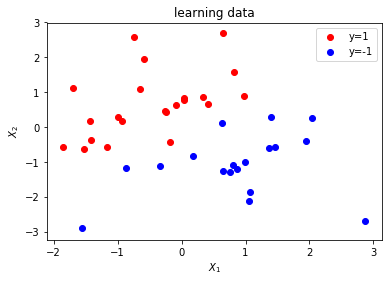

In [310]:
# 学習データをプロットする

# y=-1とy=1でデータセットを分離する

# y=1のデータ
data_p1 = [elem.x for elem in data if elem.y == 1]
# y=-1のデータ
data_m1 = [elem.x for elem in data if elem.y == -1]

# xの第1成分と第2成分を分離
data_p1x1 = [x[0] for x in data_p1]
data_p1x2 = [x[1] for x in data_p1]
data_m1x1 = [x[0] for x in data_m1]
data_m1x2 = [x[1] for x in data_m1]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(data_p1x1,data_p1x2, c='red', label='y=1')
ax.scatter(data_m1x1, data_m1x2, c='blue', label='y=-1')

ax.set_title('learning data')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.legend(loc='upper right');
fig.savefig('learning_data.png')

## 損失関数 + 正則化項
$\sigma(x) = 1/(1 + \exp(-x))$(シグモイド関数)としたとき
$$J(w) = -\frac{1}{n}\sum_{i=1}^n \log\sigma(y_iw^\top x_i) + \lambda w^\top w$$
今回、$\lambda=1$とする。

In [311]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [312]:
# 正則化項
lam = 1

In [313]:
# Jの定義
# wはベクトル
def J(w):
    # 総和の項の計算
    def f(entry):
        x = entry.x
        y = entry.y
        ywx = y * np.matmul(w.T, x)
        return np.log(sigmoid(ywx))
    return -(1/n) * sum([f(entry) for entry in data]) + lam * np.matmul(w.T, w)


## 最急降下法の実装
$$\nabla J(w) =  -\frac{1}{n}\sum_{i=1}^n [1-\sigma(y_iw^\top x)]y_ix_i + 2\lambda w$$
$$d^{(t)} = -\nabla J(w^{(t)})$$


In [314]:
# ∇Jの定義
def nablaJ(w):
    def f(entry):
        x = entry.x
        y = entry.y
        ywx = y * np.matmul(w.T, x)
        return (1-sigmoid(ywx)) * y * x
    return -(1/n) * sum([f(entry) for entry in data]) + 2 * lam * w
    

In [315]:
# 更新ベクトルの計算 (w(t+1)= w(t) + alpha(t) d(t) のd(t))
def delta(w):
     return - nablaJ(w)

alpha = 1/(2 * lam) # ∇Jのリプシッツ定数の逆数

In [316]:
numIterations = 100
wlist = []
w0 = np.array([[0.0],[0.0]])# wの初期値
wlist.append(w0)

for i in range(1, numIterations):
    wold = wlist[i-1]
    wnew = wold + alpha * delta(wold)
    wlist.append(wnew)

wresult = wlist[-1] # 再急降下法の結果

print("w, j")

jlist = [J(w) for w in wlist]
for w, j in zip(wlist, jlist):
    print(w,j)


w, j
[[0.]
 [0.]] [[0.69314718]]
[[-0.16131332]
 [ 0.21357596]] [[0.63683859]]
[[-0.12919059]
 [ 0.16718733]] [[0.63429437]]
[[-0.13539802]
 [ 0.17675412]] [[0.634191]]
[[-0.13416339]
 [ 0.17476811]] [[0.63418665]]
[[-0.13441071]
 [ 0.17517782]] [[0.63418647]]
[[-0.13436079]
 [ 0.17509347]] [[0.63418646]]
[[-0.13437091]
 [ 0.1751108 ]] [[0.63418646]]
[[-0.13436885]
 [ 0.17510725]] [[0.63418646]]
[[-0.13436927]
 [ 0.17510798]] [[0.63418646]]
[[-0.13436919]
 [ 0.17510783]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510786]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-

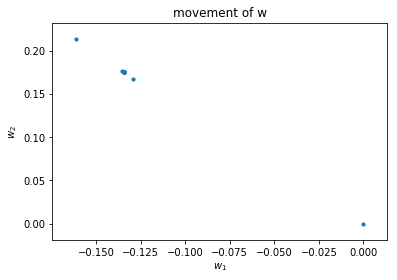

In [320]:
# wの収束の様子

w1list = [w[0] for w in wlist]
w2list = [w[1] for w in wlist]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(w1list, w2list, s=10)

ax.set_title('movement of w')
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$');


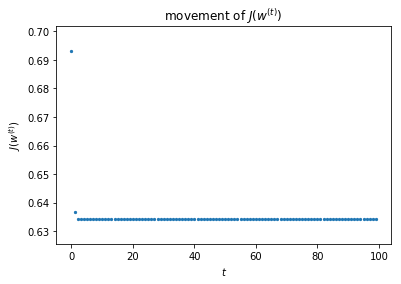

In [321]:
# J(w)の収束の様子
iteration = range(0,numIterations)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(iteration, jlist, s=5)

ax.set_title('movement of $J(w^{(t)})$')
ax.set_xlabel('$t$')
ax.set_ylabel('$J(w^{(t)})$');


/Users/paruma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


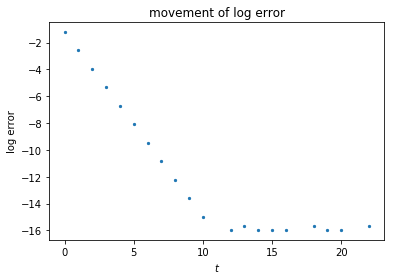

In [322]:
# 収束値をw*としたときのlog |J(w(t)) - J(w*)| (対数誤差)のグラフ

logerror = [np.log10(np.abs(j - J(wresult))) for j in jlist]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(iteration, logerror, s=5)

ax.set_title('movement of log error')
ax.set_xlabel('$t$')
ax.set_ylabel('log error');


0ステップ目から10ステップ目を見ると、対数誤差はステップ数に対して線形の速さで小さくなっていることがわかる。
$11$ステップ目以降不規則な挙動をしている。(プロットされていない$t=11,16,21$と$t\geq 23$については計算結果が$\mathrm{inf}$となった。$\mathrm{inf}$となったのは、誤差$|J(\hat w) - J(w^{(t)})|$が$0$になったからである。)
そのことについて説明する。\\
$\nabla J(w) = -(1/n) \sum_{i=1}^n [1-\sigma(y_iw^\top x_i)]y_ix_i + 2\lambda w$の計算で、$t$が十分大きいとき、$(1/n) \sum_{i=1}^n [1-\sigma(y_i w^\top x)]y_ix_i$と$2\lambda w$がほとんど等しいため、この2つの値の引き算でアンダーフローが発生している。
数値計算では64bitの浮動小数点を使っているため、有効数字は15桁程度である。
$(1/n) \sum_{i=1}^n [1-\sigma(y_i w^\top x)]y_ix_i$と$2\lambda w$は$10^{-1}$のオーダーの値なので、$\nabla J(w)$絶対値がは$10^{-16}$(程度)未満の場合正しく計算することができない。これが$11$ステップ目以降不規則な挙動をする原因である。

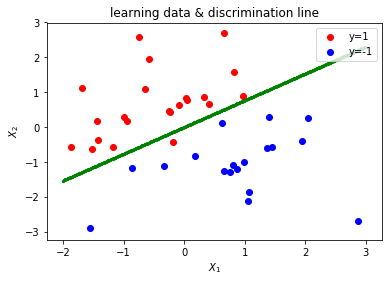

In [325]:
# 学習データ + 識別線

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# 学習データ
ax.scatter(data_p1x1,data_p1x2, c='red', label='y=1')
ax.scatter(data_m1x1, data_m1x2, c='blue', label='y=-1')

ax.set_title('learning data & discrimination line')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.legend(loc='upper right');

# 識別線
linex = np.arange(-2,3,0.01)
# w1*x + w2*y = 0より、y = -(w1/w2)x が識別線
liney = -wresult[0]/wresult[1] * linex
ax.scatter(linex, liney,c='green', s=5);


## ニュートン法の実装
$$\nabla^2 J(w) = \frac{1}{n} \sum_{i=1}^n \sigma(y_iw^\top x_i) (1- \sigma(y_iw^\top x_i)) x_ix_i^\top + 2\lambda I$$
$$d^{(t)} = -(\nabla^2 J(w^{(t)}))^{-1} \nabla J(w^{(t)})$$

In [326]:
def hessianJ(w):
    # 総和の項
    def f(entry):
        x = entry.x
        y = entry.y
        ywx =  y * np.matmul(w.T,x)
        return sigmoid(ywx) * (1-sigmoid(ywx)) * np.matmul(x, x.T)
    return (1/n) * sum([f(entry) for entry in data] + 2 * lam * np.eye(2))

In [327]:
def delta(w):
    return -np.matmul(np.linalg.inv(hessianJ(w)), nablaJ(w))

alpha = 1 # 学習率

In [328]:
numIterations = 100
wlist = []
w0 = np.array([[0],[0]])# wの初期値
wlist.append(w0)

for i in range(1, numIterations):
    wold = wlist[i-1]
    wnew = wold + alpha * delta(wold)
    wlist.append(wnew)

wresult = wlist[-1] # 再急降下法の結果

print("w, j")

jlist = [J(w) for w in wlist]
for w, j in zip(wlist, jlist):
    print(w,j)


w, j
[[0]
 [0]] [[0.69314718]]
[[-0.13383627]
 [ 0.17443294]] [[0.63418735]]
[[-0.13436918]
 [ 0.17510782]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-0.1343692 ]
 [ 0.17510785]] [[0.63418646]]
[[-

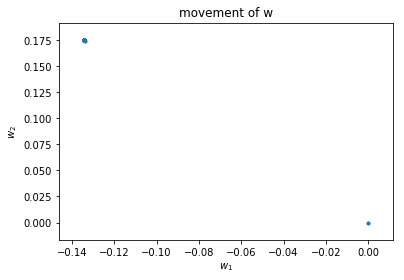

In [334]:
# wの収束の様子

w1list = [w[0] for w in wlist]
w2list = [w[1] for w in wlist]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(w1list, w2list, s=10)

ax.set_title('movement of w')
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$');


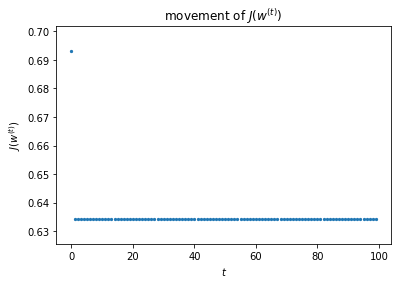

In [336]:
# J(w)の収束の様子
iteration = range(0,numIterations)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(iteration, jlist, s=5)

ax.set_title('movement of $J(w^{(t)})$')
ax.set_xlabel('$t$')
ax.set_ylabel('$J(w^{(t)})$');


/Users/paruma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


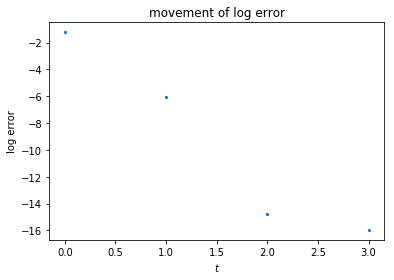

In [337]:
# 収束値をw*としたときのlog |J(w(t)) - J(w*)| (対数誤差)のグラフ

logerror = [np.log10(np.abs(j - J(wresult))) for j in jlist]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# 4ステップ目以降は数値上J(w(t)) = J(w*)になっている。(数値上収束しきっている)
ax.scatter(iteration, logerror, s=5)

ax.set_title('movement of log error')
ax.set_xlabel('$t$')
ax.set_ylabel('log error');


最急降下法より速く収束している。
正しく計算できている0ステップ目から2ステップ目を見ると、対数誤差はステップ数に対して直線より速く小さくなっている(上に凸になっている)ことがわかる。

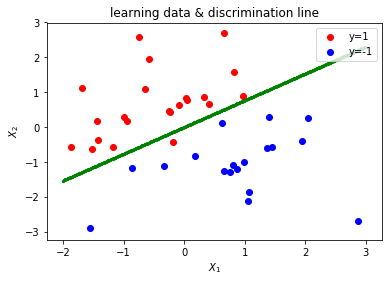

In [338]:
# 学習データ + 識別線

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# 学習データ
ax.scatter(data_p1x1,data_p1x2, c='red', label='y=1')
ax.scatter(data_m1x1, data_m1x2, c='blue', label='y=-1')

ax.set_title('learning data & discrimination line')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.legend(loc='upper right');

# 識別線
linex = np.arange(-2,3,0.01)
# w1*x + w2*y = 0より、y = -(w1/w2)x が識別線
liney = -wresult[0]/wresult[1] * linex
ax.scatter(linex, liney,c='green', s=5);
fig.savefig('newton_result.png')

## メモ
* Python3.6.5

